In [58]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


#Don't need t=0.
df = pd.read_csv('/Users/demetri/Desktop/theoph.csv')
df.head()
df['Concentration'] = 1e-3*df.conc

#Create a table of data. Subjects x Time
Ys = df.query('Time>0').pivot('Subject','Time','Concentration')
Y = Ys.values

t = np.sort(df.Time.unique())

#Vectorize the function
@np.vectorize
def func(t,V,k,k_a):
    return (2.5/V)*(k_a/(k_a- k))*(np.exp(-k * t) - np.exp(-k_a * t))


YHAT = []
for subject, frame in df.groupby('Subject'):
    
    t = frame.Time.values
    y = frame.conc.values

    p,c = curve_fit(func,xdata=t[~np.isnan(y)],ydata=y[~np.isnan(y)], p0= [100,1,1/2], bounds=(3*[0], 3*[np.inf]))

    y_hat = func(t,*p)

    f = pd.DataFrame({'Subject':subject, 'Time':t, 'Concentration':y, 'predicted':y_hat})
    YHAT.append(f)



In [59]:
m = pd.concat(YHAT)

In [60]:
# preds = pd.DataFrame(YHAT, index=Ys.index, columns=Ys.columns).stack().to_frame('predicted').reset_index()

In [61]:
# m = preds.merge(df, on=['Subject','Time'], how = 'inner')

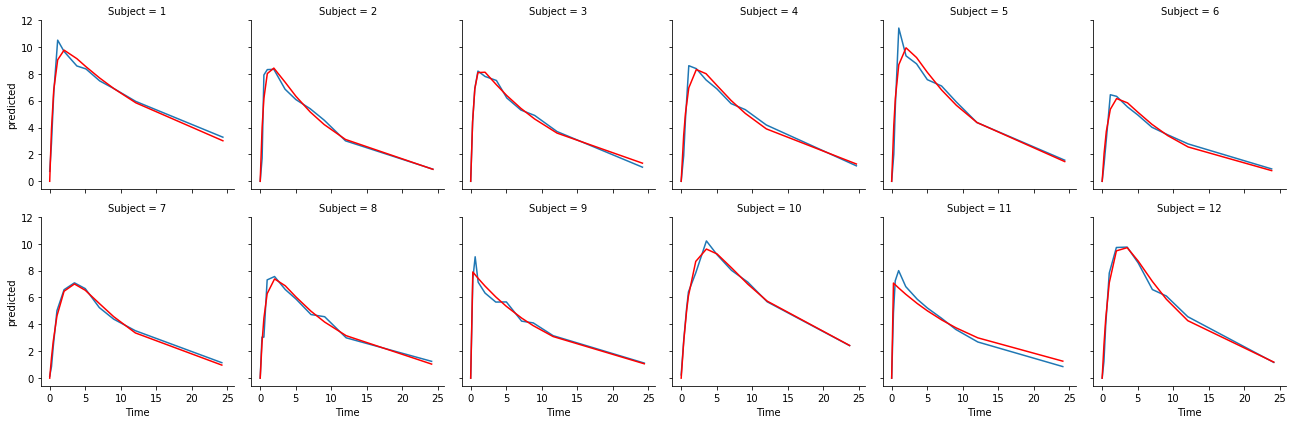

In [62]:
g = sns.FacetGrid(data = m, col = 'Subject', col_wrap=6)

g.map(plt.plot,'Time','Concentration').add_legend()
g.map(plt.plot,'Time','predicted', color = 'red')

In [65]:
m['residual'] = m.Concentration - m.predicted

In [64]:

g = sns.FacetGrid(data = m, row='Group', col = 'Sex', col_order=['Female','Male'],
                 row_order = ['Control','NAFLD'])




g.map_dataframe(sns.lineplot, x = 'Time',y = 'residual',err_style="bars", ci=95)
g.map(plt.axhline,color = 'red')
plt.tight_layout()

plt.savefig("1comp.pdf")

KeyError: 'Group'

In [ ]:
g = sns.FacetGrid(data = m, col='Time', col_wrap=4)

g.map(plt.hist,'residual', bins = np.linspace(-0.5,0.5,11), edgecolor = 'white').add_legend()

plt.tight_layout()
plt.savefig('res.pdf')


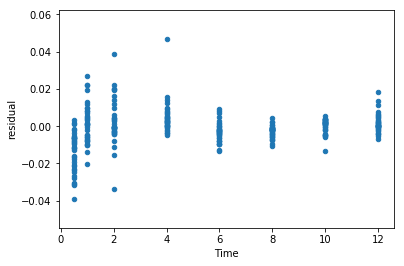

In [36]:
ax = m.plot.scatter(x = 'Time', y = 'residual')


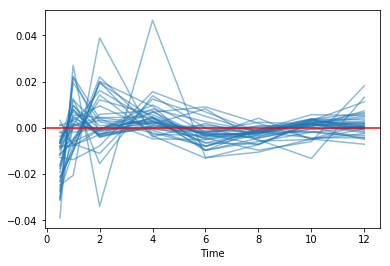

In [37]:
ax = m.pivot('Time','Subject','residual').plot(color = 'C0', legend = False, alpha = 0.5)
ax.axhline(0, color = 'red')


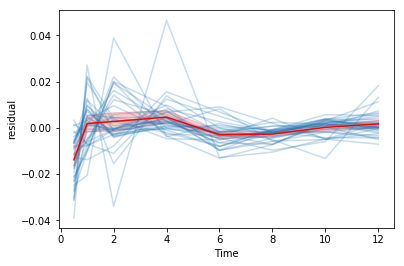

In [38]:
sns.lineplot(data = m, x = 'Time',y = 'residual', units = 'Subject', estimator=None, alpha = 0.25)
sns.lineplot(data = m, x = 'Time',y = 'residual', color = 'red')

In [39]:
m.round(2).to_clipboard(index = False)

/Users/demetri/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


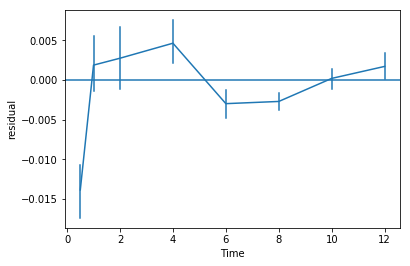

In [40]:
ax = sns.lineplot(data = m, x = 'Time', y = 'residual', err_style='bars', ci = 95)
ax.axhline(0)

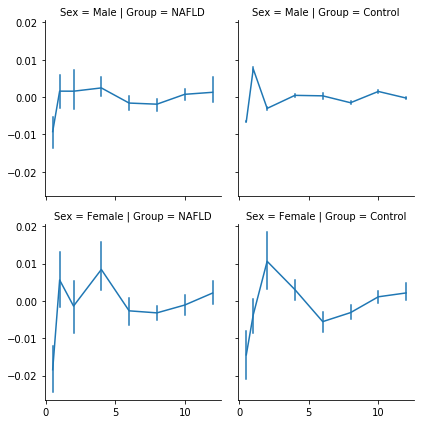

In [41]:
g = sns.FacetGrid(data = m, row = 'Sex', col = 'Group')
g.map_dataframe(sns.lineplot, x= 'Time', y = 'residual', err_style = 'bars', ci = 95)
